<a href="https://colab.research.google.com/github/betogaona7/Grounded-Segment-Anything/blob/main/grounded_sam_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install

In [ ]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything 
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

## Imports

In [3]:
%cd c:/Users/Biele/Desktop/Andoni/Ground Dino with Sam

# YOLO
from ultralytics import YOLO

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np

%cd Grounded-Segment-Anything/EfficientSAM/
from RepViTSAM.setup_repvit_sam import build_sam_repvit
from MobileSAM.setup_mobile_sam import setup_model
from FastSAM.tools import *

%cd c:/Users/Biele/Desktop/Andoni/Ground Dino with Sam
# diffusers
import torch
import time
from patchify import patchify
from PIL import Image
import matplotlib.pyplot as plt 
Image.MAX_IMAGE_PIXELS = None

c:\Users\Biele\Desktop\Andoni\Ground Dino with Sam


c:\Users\Biele\.conda\envs\vision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Biele\Desktop\Andoni\Ground Dino with Sam\Grounded-Segment-Anything\EfficientSAM
c:\Users\Biele\Desktop\Andoni\Ground Dino with Sam


## Load models

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## YOLO

In [5]:
yolo = YOLO('C:/Users/Biele/Desktop/Andoni/Yolo/runs/detect/train4/weights/best.pt')

In [6]:
# detect object using grounding DINO
def detect(image, model, box_threshold = 0.3):
  
  detections = yolo(image, conf=box_threshold)

  boxes = detections[0].boxes.xyxy.cpu().numpy()
  

  return boxes 

## RepVIT-SAM for segmentation

In [ ]:
!wget -P EfficientSAM/ https://github.com/THU-MIG/RepViT/releases/download/v1.0/repvit_sam.pt

In [ ]:
sam_checkpoint = 'EfficientSAM/repvit_sam.pt'

repvit_sam = build_sam_repvit(checkpoint=sam_checkpoint)
repvit_sam.to(device=device)

sam_predictor = SamPredictor(repvit_sam)

In [6]:
# Prompting SAM with detected boxes
def segment_rep(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False,
            hq_token_only=True,
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [35]:
# image = Image.open(r'C:\Users\Biele\Desktop\Barlinek\Imagenes Barlinek Cola\imagen789.tiff')
# image = ImageOps.grayscale(image)
image = cv2.imread(r'C:\Users\Biele\Desktop\Barlinek\Imagenes Barlinek Cola\imagen789.tiff')
# patches = patchify(image, (8192, 8192, 3), step=8192)
# patches = patches.reshape(-1 ,8192, 8192, 3)
# patches = patches[80:-48]

### All Inference

In [37]:
# image = patches[0]
# image = cv2.imread(r'C:\Users\Biele\Desktop\Barlinek\Imagenes Barlinek Cola\imagen789.tiff')
hasi = time.time()
detected_boxes = detect(image, model=yolo)
det = time.time()
segmented_image = segment_rep(
    sam_predictor=sam_predictor,
    image=np.array(image),
    xyxy=detected_boxes
)
bukatu = time.time()
print(f'Det {det-hasi} Seg {bukatu-det} All {bukatu-hasi}')
# Image.fromarray(segmented_image[0,...])


0: 512x288 1 Tableroa, 81.9ms
Speed: 5.5ms preprocess, 81.9ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 288)
Det 0.09381914138793945 Seg 2.6566312313079834 All 2.750450372695923


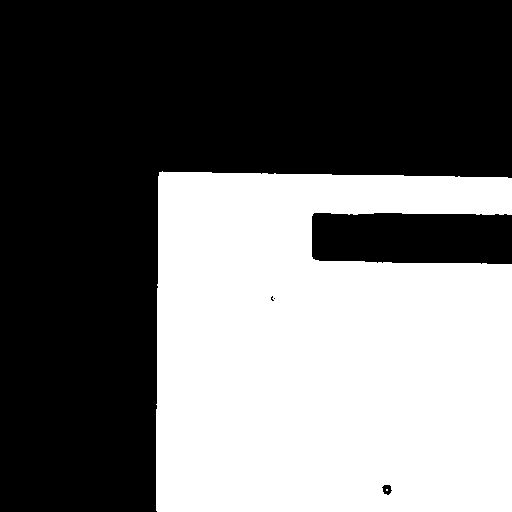

In [78]:
Image.fromarray(segmented_image[0,...])

## MobileSAM for segmentation

https://github.com/ChaoningZhang/MobileSAM/blob/master/weights/mobile_sam.pt

In [46]:
# Building MobileSAM predictor
MOBILE_SAM_CHECKPOINT_PATH = 'EfficientSAM\mobile_sam.pt'
checkpoint = torch.load(MOBILE_SAM_CHECKPOINT_PATH)
mobile_sam = setup_model()
mobile_sam.load_state_dict(checkpoint, strict=True)
mobile_sam.to(device=device)

sam_predictor = SamPredictor(mobile_sam)

LR SCALES: [0.08589934592000005, 0.10737418240000006, 0.13421772800000006, 0.1677721600000001, 0.20971520000000007, 0.2621440000000001, 0.3276800000000001, 0.4096000000000001, 0.5120000000000001, 0.6400000000000001, 0.8, 1.0]


In [47]:
def segment_mobile(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
      sam_predictor.set_image(image)
      result_masks = []
      for box in xyxy:
          masks, scores, logits = sam_predictor.predict(
              box=box,
              multimask_output=True
          )
          index = np.argmax(scores)
          result_masks.append(masks[index])
      return np.array(result_masks)

In [49]:
image = cv2.imread(r'C:\Users\Biele\Desktop\Barlinek\Imagenes Barlinek Cola\imagen789.tiff')
# patches = patchify(image, (8192, 8192, 3), step=8192)
# patches = patches.reshape(-1 ,8192, 8192, 3)
# patches = patches[80:-48]

In [ ]:
Image.fromarray(patches[0])

### All Inference

In [53]:
# image = patches[0]
# image = cv2.imread(r'C:\Users\Biele\Desktop\Barlinek\Imagenes Barlinek Cola\imagen789.tiff')
hasi = time.time()
detected_boxes = detect(image, model=yolo)
det = time.time()
segmented_image = segment_mobile(
    sam_predictor=sam_predictor,
    image=np.array(image),
    xyxy=detected_boxes
)
bukatu = time.time()
print(f'Det {det-hasi} Seg {bukatu-det} All {bukatu-hasi}')
# Image.fromarray(segmented_image[0,...])


0: 512x288 1 Tableroa, 170.9ms
Speed: 8.6ms preprocess, 170.9ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 288)
Det 0.18825697898864746 Seg 3.2602813243865967 All 3.448538303375244


## Light-HQ-SAM for segmentation

In [ ]:
HQSAM_CHECKPOINT_PATH = "./EfficientSAM/sam_hq_vit_tiny.pth"
checkpoint = torch.load(HQSAM_CHECKPOINT_PATH)
light_hqsam = setup_model()
light_hqsam.load_state_dict(checkpoint, strict=True)
light_hqsam.to(device=device)

sam_predictor = SamPredictor(light_hqsam)